https://segment-anything.com/demo

https://github.com/facebookresearch/segment-anything/tree/main/segment_anything

### Setup

1. mount google drive to load dataset SA-1B

2. clone repository from segment anything github and change directory to the cloned repo

3. download model checkpoint(ViT-b)

4. install necessary modules, etc.


In [1]:
# mount google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/facebookresearch/segment-anything
# cloning repo from segment anything github.
%cd segment-anything
!pip install -e .
#install the Python package located in the current directory (/PATH) in editable mode
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
!pip install opencv-python pycocotools matplotlib onnxruntime onnx


Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 295 (delta 141), reused 121 (delta 119), pack-reused 83
Receiving objects: 100% (295/295), 18.31 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/segment-anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 

In [3]:
! pip install python-box segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=190a9b3d2d9cb6d6ae38f1576a51880fb2625473d4029648d3821653fdfaae49
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrain

Requirement stated at github

> python>=3.8, as well as pytorch>=1.7 and torchvision>=0.8



In [4]:
!python --version
import torch,torchvision
print(torch.__version__, torchvision.__version__)

Python 3.10.11
2.0.1+cu118 0.15.2+cu118


In [5]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from box import Box
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools.mask

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from segment_anything.modeling import MaskDecoder, TwoWayTransformer
from segment_anything.utils.transforms import ResizeLongestSide



#### you should change this path below to your own path of the dataset ####
data_path = '/content/drive/MyDrive/Group3/SA-1B_sample/'
folder = os.listdir(data_path)

10125000

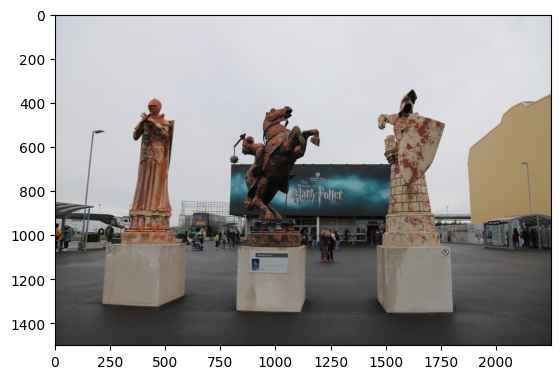

In [6]:
#check first image
img_id = folder[0][:-4]
img_id

img = cv2.imread(data_path+img_id+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.size

**Challenge #1**

There is no train.py / training method / code provided at segment_anything github.

Therefore, we had to implement the training methods by ourselves.

# Configuration

1. GPU
2. Model hyper parameters
3. Optimizer Settings
4. SAM model settings

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config = {
    "batch_size": 1,
    "num_epochs": 3,
    "eval_interval": 2,

    # optimizer settings
    "opt": {
        "learning_rate": 8e-4,
        "weight_decay": 1e-4, #0.1,
        "decay_factor": 10,
        "steps": [60000, 86666],
        "warmup_steps": 250,
    },

    # sam model settings
    "model": {
        "type": 'vit_b',
        "checkpoint": "/content/segment-anything/sam_vit_b_01ec64.pth",
        
        # parameters will be freezed if cfg.model.freeze.XX is set to True
        # In this case, we will only try to train the mask decoder.
        "freeze": {
            "image_encoder": True,
            "prompt_encoder": True,
            "mask_decoder": False,
        },
    }
}

cfg = Box(config)

**Challenge #2**

The model is too big, so we couldn't even load the model on the school GPU server.

Therefore, 

1. We used the smallest model, vit_b.
2. We loaded the model checkpoints and then initialized only the mask decoder.
3. Freeze the encoders' parameters
4. Train the model

As a result, we trained only the mask decoder from scratch.

In [8]:
MODEL_TYPE = cfg.model.type
CHECKPOINT_PATH = cfg.model.checkpoint

#declare Segment Anything Model as sam --> vit_b model declared with model checkpoint
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)



#initialize only the maskdecoder(hyper parameters are equal to the original mask decoder)
sam.mask_decoder = MaskDecoder(
            num_multimask_outputs=3,
            transformer=TwoWayTransformer(
                depth=2,
                embedding_dim=256,
                mlp_dim=2048,
                num_heads=8,
            ),
            transformer_dim=256,
            iou_head_depth=3,
            iou_head_hidden_dim=256,
        )


#load the model on the gpu
sam=sam.to(device) 

#code for freezing parameters
if cfg.model.freeze.image_encoder:
    for param in sam.image_encoder.parameters():
        param.requires_grad = False
if cfg.model.freeze.prompt_encoder:
    for param in sam.prompt_encoder.parameters():
        param.requires_grad = False
if cfg.model.freeze.mask_decoder:
    for param in sam.mask_decoder.parameters():
        param.requires_grad = False

# Set optimizer and learning rate schedule

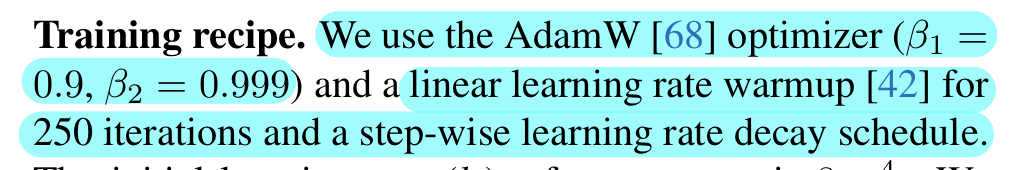

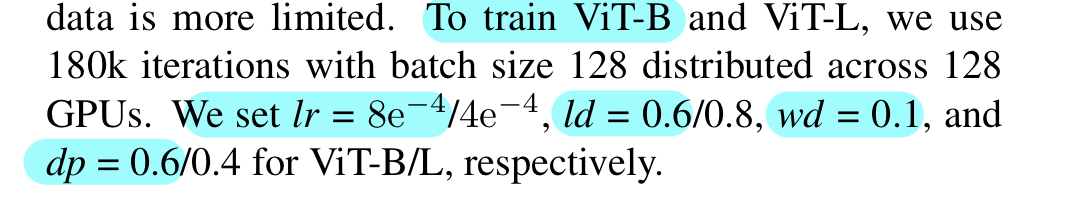

Challenge #3

In the paper, two types of learning rate decay was applied.

1. step-wise learning rate decay

2. layer-wise learning rate decay

step-wise lr decay is the scheduler in the code below.

However, we couldn't find the module or code for layer-wise lr decay, so it wasn't applied to our experimental settings.

Also, drop path should have been included, but we couldn't find exactly where within the code we had to apply it.

In [9]:
#function for learning rate scheduler
def lr_lambda(step):
        if step < cfg.opt.warmup_steps:
            return step / cfg.opt.warmup_steps
        elif step < cfg.opt.steps[0]:
            return 1.0
        elif step < cfg.opt.steps[1]:
            return 1 / cfg.opt.decay_factor
        else:
            return 1 / (cfg.opt.decay_factor**2)

            

optimizer = torch.optim.AdamW(sam.parameters(), lr=cfg.opt.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=cfg.opt.weight_decay, amsgrad=False)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Prepare data


**Challenge #4**

The model's input image size is set to be 1024*1024, which is huge. Moreover, each images in the dataset included average of 100 segmentation masks.

Therefore, loading the dataset itself onto the GPU was overwhelming the memory.

As a result, we decided to use only 10 images for training, with only 10 masks each.


We only executed training.

The reason is that it was obvious that the training would not have been done properly since we used the 1/11M amount of original dataset. 

Instead, we used this code to fine-tune the model for the other task.

Each image's json file includes the info and the annotations of the image as below.

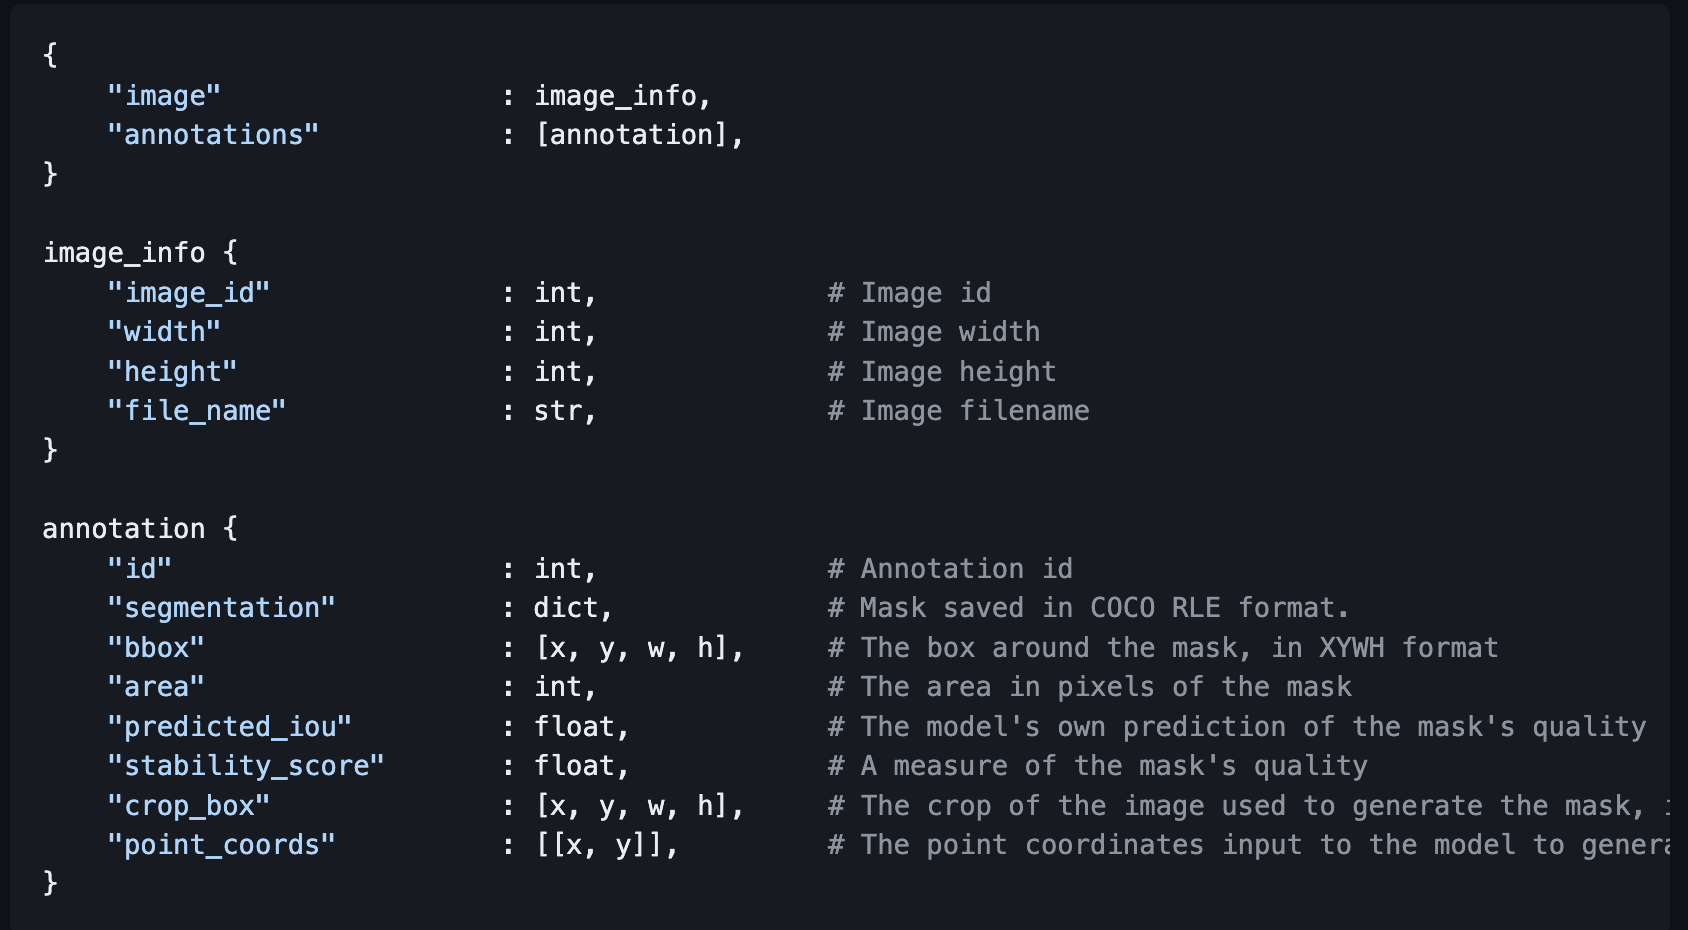

ResizeLongestSide: class for transforming each image and prompts to match the required input shape of the model.

Therefore, the longest side of the image(doesn't matter if it's h or w) will be resized to 1024.

Then, the shorter side will be padded to make the image a square of shape 1024*1024.

Prompts like point coordinates and boundary boxes will also be adjusted to match the new shape 1024*1024.

Ground truth masks are also resized and padded to match 1024*1024.

The number 1024 can be set as different number, if you change the parameter sam.image_encoder.img_size.


In [10]:
train_data = folder
train_dataset=[]

img_count = 0
ith_data=-1

# we will use 10 images, and 10 boxes per image.
will_use_img = 10
will_use_box = 10

transform = ResizeLongestSide(sam.image_encoder.img_size)

while img_count<will_use_img:
  ith_data+=1
  # The dataset is consisted of pairs of image file(sa_***.jpg) and masks file(sa_***.json).
  # We should will be accessing the image and mask data by using the img id sa_***.
  if (train_data[ith_data][-3:]=='jpg'):
    img_count+=1
    img_id=train_data[ith_data][:-4]

    with open(data_path+img_id+'.json','r') as f:
      mask_data=json.load(f)

    #Extract the data of image
    img=cv2.imread(data_path+img_id+'.jpg')

    ann = mask_data['annotations']
    bbox_count=len(ann) # count how many annotations are there in the selected image

    bboxes=[]
    gt_masks=[]

    # we will use the image only if it has more than 10 annotations.
    if (bbox_count<will_use_box):
      img_count-=1
      continue


    for j in range (will_use_box): 
      # Extract the data of boundary boxes
      x,y,w,h = ann[j]['bbox']
      bbox = [x,y,x+w,y+h]
      bboxes.append(bbox)

      # Segmentation masks are saved as COCO rle format, so we need to decode it.
      rle=ann[j]['segmentation']
      gt_mask=pycocotools.mask.decode(rle)
      gt_masks.append(gt_mask)


    bboxes = np.array(bboxes)

    og_h, og_w = img.shape[:2] # h, w of the original image
  
    input_img = transform.apply_image(img) # resize the longest side to 1024.
    input_img = torch.as_tensor(input_img, device = device).float()
    image = input_img.permute(2, 0, 1).contiguous()[None, :, :, :] # move channel dimension to the front

    _, _, h, w = image.shape # h, w of resized image
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2

    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    
    image = transforms.Pad(padding)(image) # pad the image to make it a square shape of 1024 * 1024.
    
    # groundtruth masks should also go through the same process.
    gt_masks = [torch.tensor(transform.apply_image(mask)) for mask in gt_masks] 
    gt_masks = [transforms.Pad(padding)(mask) for mask in gt_masks]
    gt_masks = np.stack(gt_masks, axis=0)
    gt_masks = torch.tensor(gt_masks, device = device).float()
    
    # boundary boxes should also be adjusted to match the new image shape.
    bboxes = transform.apply_boxes(bboxes, (og_h, og_w))
    bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]
    bboxes = np.stack(bboxes, axis=0)
    bboxes = torch.tensor(bboxes, device = device)
    bboxes = bboxes.resize(will_use_box, cfg.batch_size, 4)  

    data=[image, bboxes, gt_masks, (og_h,og_w)]
    
    train_dataset.append(data)

print(len(train_dataset)) 




/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


10


In [11]:
print("### H,W of the image and ground truth mask was been resized and padded to match 1024 * 1024 ###")
print()
print("input image shape(B * C * H * W): ",data[0].shape)
print()
print("boundary box shape(B * 4): ",data[1][0].shape)
print()
print("ground truth mask shape: ",data[2][0].shape)
print()
print("original image shape: ", data[3])

### H,W of the image and ground truth mask was been resized and padded to match 1024 * 1024 ###

input image shape(B * C * H * W):  torch.Size([1, 3, 1024, 1024])

boundary box shape(B * 4):  torch.Size([1, 4])

ground truth mask shape:  torch.Size([1024, 1024])

original image shape:  (1500, 2002)


In [12]:
class SA1BDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return sample

train_dataset=SA1BDataset(train_dataset)

#Losses



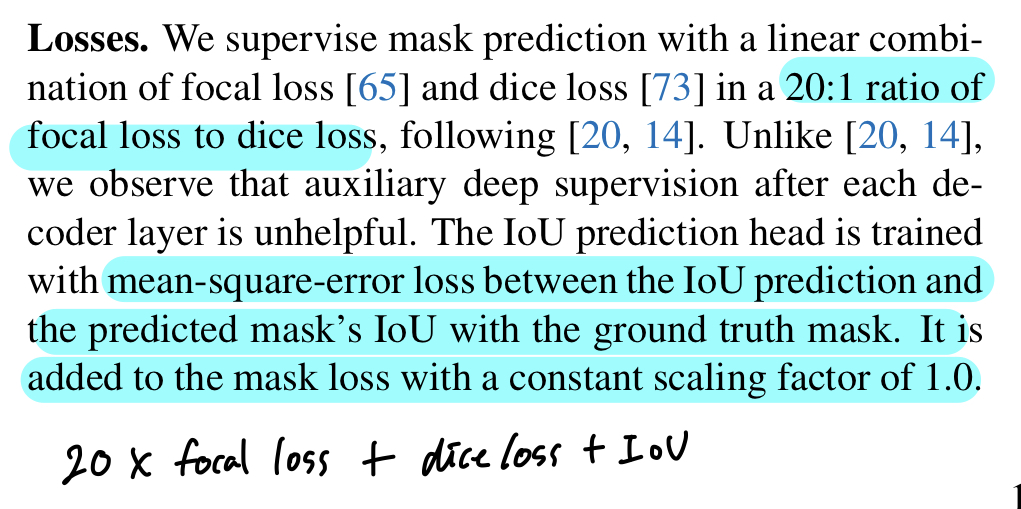

In [13]:
ALPHA = 0.8
GAMMA = 2


class FocalLoss(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Model Setup

Segment Anything Model is consisted of 3 parts.

1. Image encoder - input image in order to get image embeddings

2. Prompt endoer - input prompts(points, boundary boxes, masks, etc.) in order to get sparse embeddings(for points and boundary boxes) and dense embeddings(for masks)

3. Mask decoder - input image/sparse/dense embeddings to predict segmentation masks.

In [14]:
class Model(nn.Module):

    def __init__(self, cfg, model):
        super().__init__()
        self.cfg = cfg
        self.model = model

    def forward(self, images, bboxes):
        _, _, H, W = images.shape
        image_embeddings = self.model.image_encoder(images) # forward the input images into the image encoder to get image embeddings
        pred_masks = []
        ious = []
        for embedding, bbox in zip(image_embeddings, bboxes):
            sparse_embeddings, dense_embeddings = self.model.prompt_encoder( # forward the prompts(in this case, boundary boxes) in to the prompt encoder to get sparse/dense embeddings.
                points=None,
                boxes=bbox,
                masks=None,
            )
            # forward the image embeddings, sparse/dense embeddings into the mask decoder to get predicted (low resolution)masks and ious.
            low_res_masks, iou_predictions = self.model.mask_decoder(
                image_embeddings=embedding.unsqueeze(0),
                image_pe=self.model.prompt_encoder.get_dense_pe(), # Returns the positional encoding used to encode point prompts, applied to a dense set of points the shape of the image encoding.
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False, # multimask is to handle the ambiguity, but we don't need it for now.
            )

            masks = F.interpolate( # upsample low_res_masks by interpolating
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )

            pred_masks.append(masks.squeeze(1))
            ious.append(iou_predictions)

        return pred_masks, ious
        # returns predicted masks and ious.


In [15]:
model = Model(cfg, sam).to(device)

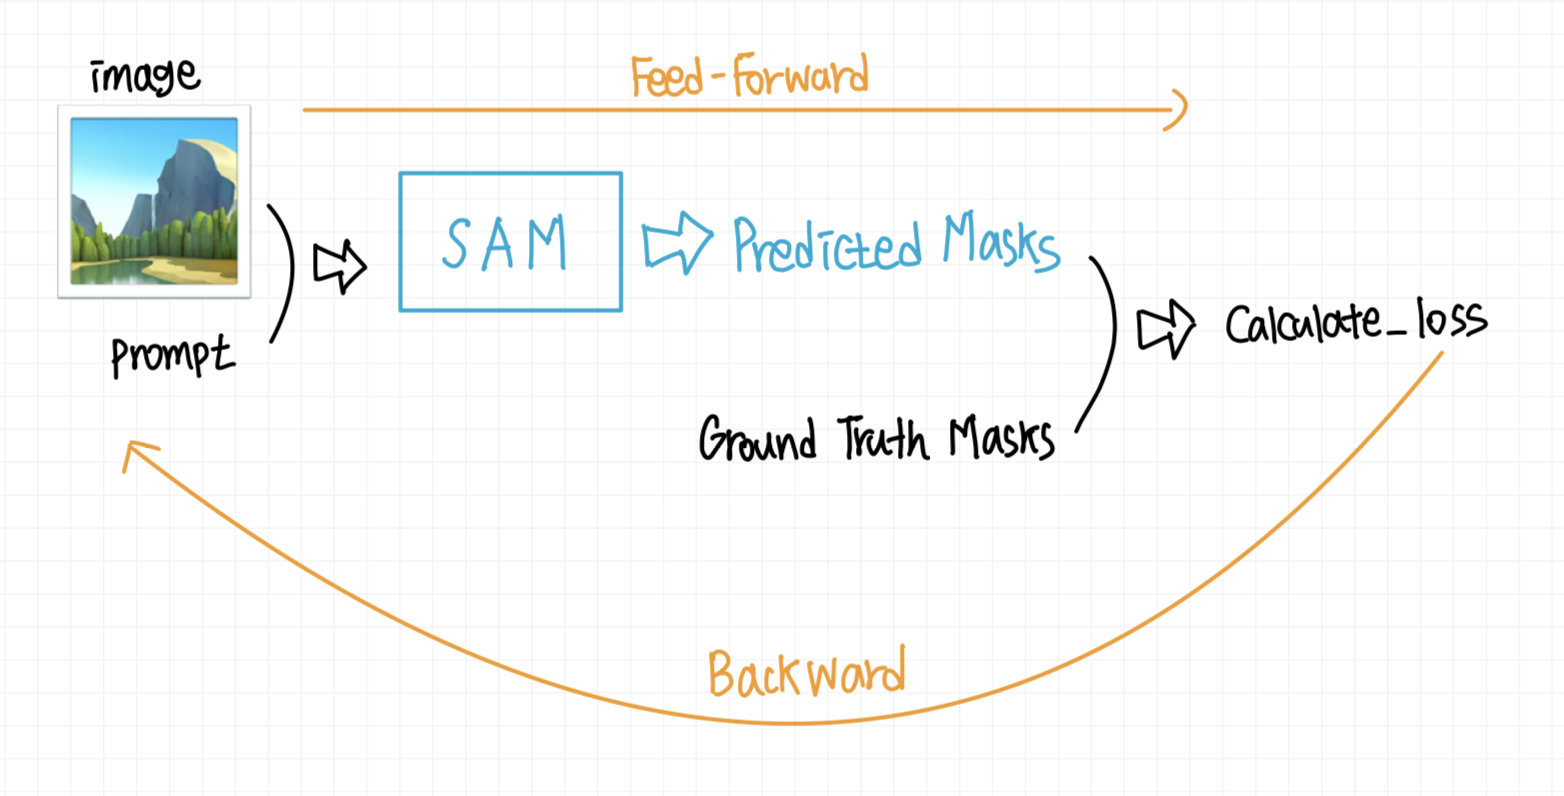

In [16]:
focal_loss = FocalLoss()
dice_loss = DiceLoss()

loss_his = []

for epoch in range(cfg.num_epochs):
  
  for iter, data in enumerate(train_dataset):
      images, bboxes, gt_masks, _ = data

      batch_size = images.size(0)
      # feed forward the input image and the prompts(in this case, boundary boxes) into the model.
      pred_masks, iou_predictions = model(images, bboxes) 
      num_masks = sum(len(pred_mask) for pred_mask in pred_masks)
      loss_focal = torch.tensor(0., device=device)
      loss_dice = torch.tensor(0., device=device)
      loss_iou = torch.tensor(0., device=device)

      # With the predicted masks and ground truth masks, we will calculate losses.
      for pred_mask, gt_mask, iou_prediction in zip(pred_masks, gt_masks, iou_predictions): 

        pred_mask = (pred_mask >= 0.5).float() # pred_mask, gt_mask의 batch_iou 계산
        intersection = torch.sum(torch.mul(pred_mask, gt_mask), dim=(1,2))
        
        union = torch.sum(pred_mask, dim=(1,2))
        epsilon = 1e-7
        batch_iou = (intersection / (union + epsilon)).unsqueeze(1)

        loss_focal += focal_loss(pred_mask, gt_mask, num_masks)
        loss_dice += dice_loss(pred_mask, gt_mask, num_masks)
        loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks

      # calculate total loss, and execute backward
      loss_total = 20. * loss_focal + loss_dice + loss_iou
      optimizer.zero_grad()
      loss_total.backward(loss_total)
      optimizer.step()
      scheduler.step()

      avg_focal = loss_focal.item() / batch_size 
      avg_dice = loss_dice.item() / batch_size
      avg_iou = loss_iou.item() / batch_size
      avg_total = loss_total.item() / batch_size
      loss_his.append(avg_total)

      print(f'-- Epoch: [{epoch+1}] Iteration: {iter+1} --')
      print(f'Focal Loss [{loss_focal.item():.4f}] [avg: {avg_focal:.4f}]')
      print(f'Dice Loss [{loss_dice.item():.4f}] [avg: {avg_dice:.4f}]')
      print(f'IoU Loss [{loss_iou.item():.4f}] [avg: {avg_iou:.4f}]')
      print(f'Total Loss [{loss_total.item():.4f}] [avg: {avg_total:.4f}] \n')

-- Epoch: [1] Iteration: 1 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.9988] [avg: 0.9988]
IoU Loss [0.0472] [avg: 0.0472]
Total Loss [4.5118] [avg: 4.5118] 

-- Epoch: [1] Iteration: 2 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.7550] [avg: 0.7550]
IoU Loss [0.0294] [avg: 0.0294]
Total Loss [4.2501] [avg: 4.2501] 

-- Epoch: [1] Iteration: 3 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.9950] [avg: 0.9950]
IoU Loss [0.0397] [avg: 0.0397]
Total Loss [4.5005] [avg: 4.5005] 

-- Epoch: [1] Iteration: 4 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.9931] [avg: 0.9931]
IoU Loss [0.0354] [avg: 0.0354]
Total Loss [4.4943] [avg: 4.4943] 

-- Epoch: [1] Iteration: 5 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.9994] [avg: 0.9994]
IoU Loss [0.0178] [avg: 0.0178]
Total Loss [4.4829] [avg: 4.4829] 

-- Epoch: [1] Iteration: 6 --
Focal Loss [0.1733] [avg: 0.1733]
Dice Loss [0.9984] [avg: 0.9984]
IoU Loss [0.0259] [avg: 0.0259]
Total Loss [4.4900] [avg: 4.4900] 

-- Epoch: 

# Train loss visualization

Since we set the batch size as 1, each iter will only use 1 image for training.

Therefore, the loss for the same iter will be a loss for the same single image.

As you can see, except for iter 4,7, the train loss was decreased in epoch 3, compared to epoch 1.

To see the difference of the loss clearly, the loss showed is a loss of power of 6.

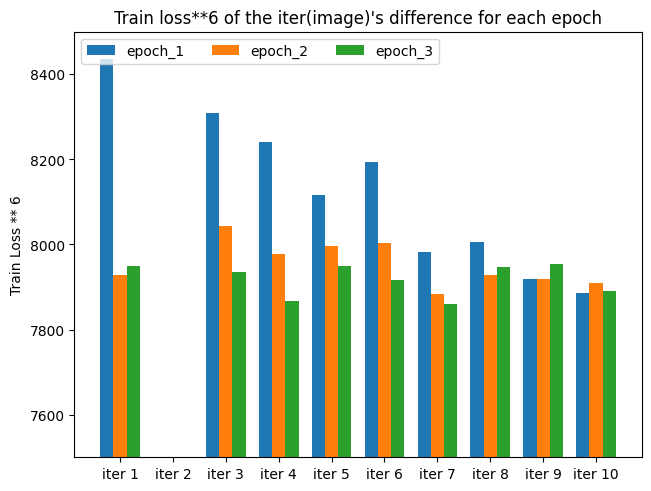

In [17]:
iter = ['iter '+str(x+1) for x in range(10)]

# Loss ** 6 was executed since the difference was too small
epochs = {
    'epoch_1': [x**6 for x in loss_his[0:10]],
    'epoch_2': [x**6 for x in loss_his[10:20]],
    'epoch_3': [x**6 for x in loss_his[20:]],
}

x = np.arange(len(iter))  
width = 0.25 
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in epochs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    multiplier += 1


ax.set_ylabel('Train Loss ** 6')
ax.set_title("Train loss**6 of the iter(image)'s difference for each epoch")
ax.set_xticks(x + width, iter)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(7500, 8500)

plt.show()

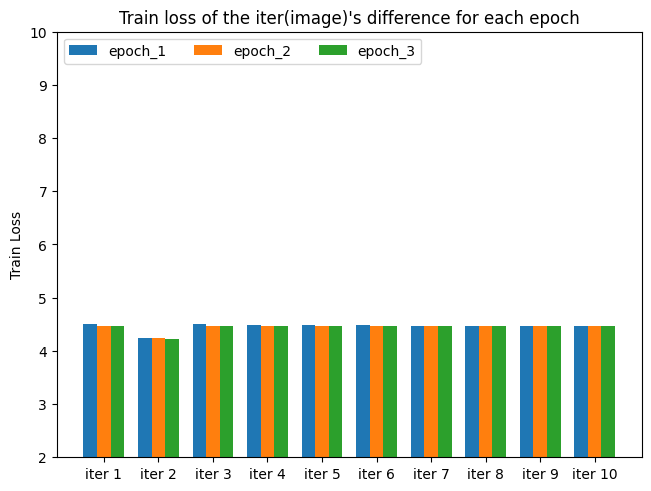

In [18]:
iter = ['iter '+str(x+1) for x in range(10)]

# without Loss ** 6
epochs = {
    'epoch_1': [x for x in loss_his[0:10]],
    'epoch_2': [x for x in loss_his[10:20]],
    'epoch_3': [x for x in loss_his[20:]],
}

x = np.arange(len(iter))  
width = 0.25 
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in epochs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    multiplier += 1


ax.set_ylabel('Train Loss')
ax.set_title("Train loss of the iter(image)'s difference for each epoch")
ax.set_xticks(x + width, iter)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(2, 10)

plt.show()